# Quick recap of EC algorithms and applications

This notebook provides an overview of evolutionary computation (EC) algorithms and some applications. It is not our goal to discuss all the theories and techniques behind EC algorithms, but to review their key features, especially those related to their search behaviours. Then we show how to set up EC algorithms using `deap`. 

Those who are not familiar with EC can find the following materials useful:

* [Essentials of Metaheuristics (Sean Luke)](https://cs.gmu.edu/~sean/book/metaheuristics/)
* [A Field Guide to Genetic Programming (Nicholas F. McPhee, Riccardo Poli, and William B. Langdon)](http://www0.cs.ucl.ac.uk/staff/W.Langdon/ftp/papers/poli08_fieldguide.pdf)
* [Swarm Intelligence (Russell Eberhart Yuhui Shi James Kennedy)](https://www.elsevier.com/books/swarm-intelligence/eberhart/978-1-55860-595-4)


# Evolutionary Computation

Evolutionary computation (EC) is a computational intelligence approach inspired from natural evolution. EC algorithms have been used to solve a wide range of optimisation problems in engineering, finance, supply chain management, etc. Special EC algorithms such as genetic programming (GP) can be used for machine learning (ML) or applied to train machine learning models.

Most EC algorithms are population-based solvers in which a population of candidate solutions are randomly generated and evolve across many generations. Individuals in the population are evaluated with a fitness function that determines how well this individual solves or comes close to solving the problem. To evolve solutions, a wide range of pertubation operators can be applied. Some operators inspired from natural evolution, such as crossover, mutation, selection, and reproduction, are applied to create new individuals based on competitive parents. These operatiors can be found in popular EC algorithms such as genetic algorithms (GA), genetic programming (GP), and different evolution (DE). 

![alt text](https://www.doc.ic.ac.uk/project/examples/2005/163/g0516312/images/a.gif)

Meanwhile, some EC algorithms rely on swarm behaviours such as particle swarm optimisation (PSO) and and ant colony optimisation (ACO). Different from evolution operators, swarm intelligence algorithms emphasise on experiences of individuals as well as the cummunications between individuals (e.g. pheromone updating in ACO).

![pso](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/ParticleSwarmArrowsAnimation.gif/330px-ParticleSwarmArrowsAnimation.gif)



# Genetic algorithm for solving OneMax problem

In [0]:
!pip install deap
!pip install statannot
import random
import numpy
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
sns.set()

     |████████████████████████████████| 163kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2
    
    
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [0]:
def run_genetic(seed, popsize, ngen, mutateprob, crossprob):
    random.seed(seed)
    np.random.seed(seed)
    records = []
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    pop = toolbox.population(n=popsize)
    CXPB, MUTPB, NGEN = crossprob, mutateprob, ngen

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)
        # # Apply crossover and mutation on the offspring

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        record = stats.compile(pop)
        # print("Gen#{}\t{:8.2f}\t{:8.2f}\t{:8.2f}".format(g, record["min"], record["avg"], record["max"]))
        # records.append([g, record["min"], record["avg"], record["max"]])
        # The population is entirely replaced by the offspring
        for i in range(len(pop)):
            records.append([g, i, pop[i].fitness.values[0]])
        pop[:] = offspring

    return records

In [0]:
dtypes = numpy.dtype([
          ('seed', int),
          ('gen', int),
          ('mutate', float),
          ('id', int),
          ('fitness', float),
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)
for m in [0.1, 0.3, 0.5]:
  for seed in range(1,31):
    records = run_genetic(seed=seed, popsize=50, ngen=200, mutateprob=m, crossprob=0.5)
    records = pd.DataFrame(np.array(records), columns=["gen","id","fitness"])
    records["seed"] = seed
    records["mutate"] = m
    df = df.append(records)
df.tail()

,seed,gen,mutate,id,fitness
9995,30,199.0,0.5,45.0,96.0
9996,30,199.0,0.5,46.0,96.0
9997,30,199.0,0.5,47.0,97.0
9998,30,199.0,0.5,48.0,96.0
9999,30,199.0,0.5,49.0,90.0


In [0]:
df.shape

(900000, 5)

In [0]:
def vis_evo_progress(df, beststr, factor):
  groupdf = df.groupby(['seed','gen',factor]).agg(beststr).reset_index()
  plt.figure(figsize=(10,7))
  ax = sns.lineplot(x="gen", y="fitness", hue=groupdf[factor].astype("category"), data=groupdf)
  ax.set_xlabel("Generation")
  ax.set_ylabel("Best Fitness")
  return ax #, groupdf

In [0]:
def vis_evo_best(df, beststr, factor):
  groupdf = df.groupby(['seed', factor]).agg(beststr).reset_index()
  plt.figure(figsize=(7,7))
  ax = sns.boxplot(x=factor, y="fitness", data=groupdf)
  ax.set_xlabel("{}".format(factor))
  ax.set_ylabel("Fitness")
  fset = np.unique(df[factor])
  pairs = []
  for i in range(len(fset)):
    for j in range(len(fset)):
      if j > i:
        pairs.append((fset[i],fset[j]))
  test_results = add_stat_annotation(ax, data=groupdf, x=factor, y="fitness", 
                                    box_pairs=pairs,
                                    test='Mann-Whitney', text_format='star',
                                    loc='outside', verbose=2)
  return ax #, groupdf, test_results

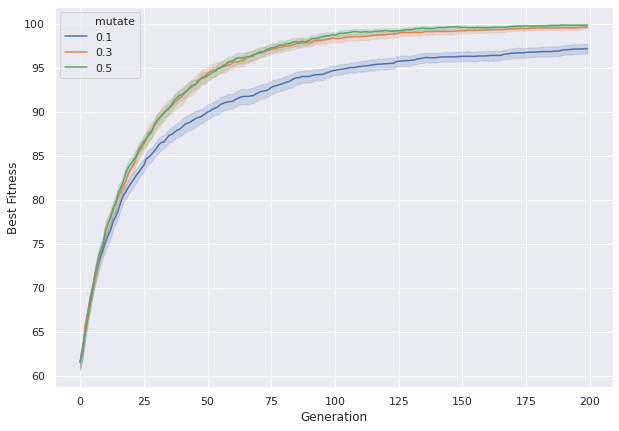

In [0]:
vis_evo_progress(df, "max", "mutate")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0.1 v.s. 0.3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.461e-09 U_stat=5.250e+01
0.3 v.s. 0.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.862e-02 U_stat=3.300e+02
0.1 v.s. 0.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.024e-11 U_stat=3.250e+01


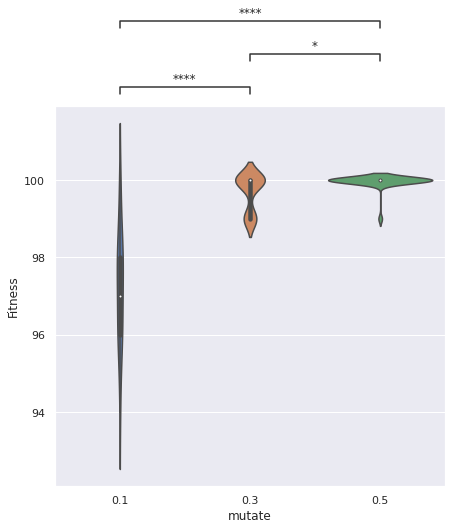

In [0]:
vis_evo_best(df, "max", "mutate")

# Genetic algorithms for Travelling Salesman Problem (TSP)

In [0]:
import array
import random
import json

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

data = '''\
{\
"TourSize" : 17,\
"OptTour" : [15, 11, 8, 4, 1, 9, 10, 2, 14, 13, 16, 5, 7, 6, 12, 3, 0],\
"OptDistance" : 2085,\
"DistanceMatrix" :\
    [[0, 633, 257, 91, 412, 150, 80, 134, 259, 505, 353, 324, 70, 211, 268, 246, 121],\
    [633, 0, 390, 661, 227, 488, 572, 530, 555, 289, 282, 638, 567, 466, 420, 745, 518],\
    [257, 390, 0, 228, 169, 112, 196, 154, 372, 262, 110, 437, 191, 74, 53, 472, 142],\
    [91, 661, 228, 0, 383, 120, 77, 105, 175, 476, 324, 240, 27, 182, 239, 237, 84],\
    [412, 227, 169, 383, 0, 267, 351, 309, 338, 196, 61, 421, 346, 243, 199, 528, 297],\
    [150, 488, 112, 120, 267, 0, 63, 34, 264, 360, 208, 329, 83, 105, 123, 364, 35],\
    [80, 572, 196, 77, 351, 63, 0, 29, 232, 444, 292, 297, 47, 150, 207, 332, 29],\
    [134, 530, 154, 105, 309, 34, 29, 0, 249, 402, 250, 314, 68, 108, 165, 349, 36],\
    [259, 555, 372, 175, 338, 264, 232, 249, 0, 495, 352, 95, 189, 326, 383, 202, 236],\
    [505, 289, 262, 476, 196, 360, 444, 402, 495, 0, 154, 578, 439, 336, 240, 685, 390],\
    [353, 282, 110, 324, 61, 208, 292, 250, 352, 154, 0, 435, 287, 184, 140, 542, 238],\
    [324, 638, 437, 240, 421, 329, 297, 314, 95, 578, 435, 0, 254, 391, 448, 157, 301],\
    [70, 567, 191, 27, 346, 83, 47, 68, 189, 439, 287, 254, 0, 145, 202, 289, 55],\
    [211, 466, 74, 182, 243, 105, 150, 108, 326, 336, 184, 391, 145, 0, 57, 426, 96],\
    [268, 420, 53, 239, 199, 123, 207, 165, 383, 240, 140, 448, 202, 57, 0, 483, 153],\
    [246, 745, 472, 237, 528, 364, 332, 349, 202, 685, 542, 157, 289, 426, 483, 0, 336],\
    [121, 518, 142, 84, 297, 35, 29, 36, 236, 390, 238, 301, 55, 96, 153, 336, 0]]\
}\
'''
# gr*.json contains the distance map in list of list style in JSON format
# Optimal solutions are : gr17 = 2085, gr24 = 1272, gr120 = 6942

tsp = json.loads(data)

distance_map = tsp["DistanceMatrix"]
IND_SIZE = tsp["TourSize"]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalTSP(individual):
    distance = distance_map[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += distance_map[gene1][gene2]
    return distance,

toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
dtypes = numpy.dtype([
          ('seed', int),
          ('gen', int),
          ('mutate', float),
          ('id', int),
          ('fitness', float),
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)
for m in [0.1, 0.3, 0.5]:
  for seed in range(1,31):
    records = run_genetic(seed=seed, popsize=50, ngen=200, mutateprob=m, crossprob=0.5)
    records = pd.DataFrame(np.array(records), columns=["gen","id","fitness"])
    records["seed"] = seed
    records["mutate"] = m
    df = df.append(records)
df.tail()

,seed,gen,mutate,id,fitness
9995,30,199.0,0.5,45.0,2158.0
9996,30,199.0,0.5,46.0,3847.0
9997,30,199.0,0.5,47.0,2498.0
9998,30,199.0,0.5,48.0,2158.0
9999,30,199.0,0.5,49.0,2158.0


We reuse the previously developed visualisation funtion here.

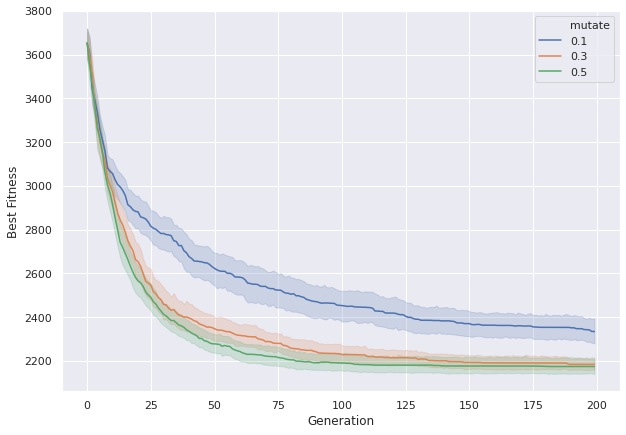

In [0]:
vis_evo_progress(df, "min", "mutate")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0.1 v.s. 0.3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.051e-05 U_stat=7.415e+02
0.3 v.s. 0.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.454e-01 U_stat=5.285e+02
0.1 v.s. 0.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.139e-06 U_stat=7.770e+02


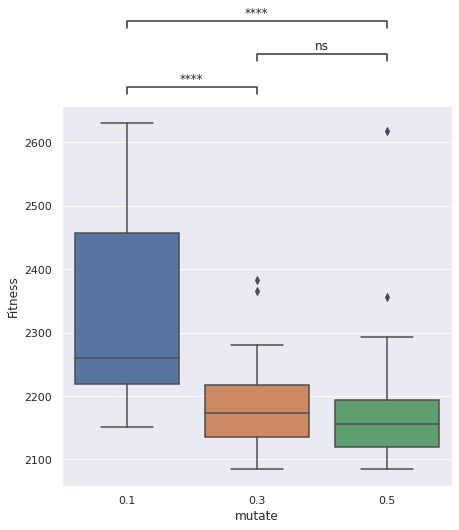

In [0]:
vis_evo_best(df, "min", "mutate")

# Particle Swarm Optimisation for Function Optimisation

In [0]:
import operator
import random
import numpy
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import math

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", numpy.ndarray, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(numpy.random.uniform(pmin, pmax, size)) 
    part.speed = numpy.random.uniform(smin, smax, size)
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(part, best, phi1, phi2):
    u1 = numpy.random.uniform(0, phi1, len(part))
    u2 = numpy.random.uniform(0, phi2, len(part))
    v_u1 = u1 * (part.best - part)
    v_u2 = u2 * (best - part)
    part.speed += v_u1 + v_u2
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part += part.speed

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=2, pmin=-100, pmax=100, smin=-1, smax=1)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=1.4, phi2=1.4)
toolbox.register("evaluate", benchmarks.h1)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
def run_pso(seed, popsize, maxeval):
    random.seed(seed)
    np.random.seed(seed)
    records = []
    pop = toolbox.population(n=popsize)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 100000
    best = None

    for g in range(GEN):
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if part.best is None or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if best is None or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        for part in pop:
            toolbox.update(part, best)

        # Gather all the fitnesses in one list and print the stats
        # logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        # print(logbook.stream)

        for i in range(len(pop)):
            records.append([g*popsize, i, pop[i].fitness.values[0]])
        
        if (g+1)*popsize > maxeval:
            break
    
    return records #pop, logbook, best

In [0]:
dtypes = numpy.dtype([
          ('seed', int),
          ('gen', int),
          ('popsize', float),
          ('id', int),
          ('fitness', float),
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)
for p in [10, 20, 30, 40]:
  for seed in range(1,31):
    records = run_pso(seed=seed, popsize=p, maxeval=10000)
    records = pd.DataFrame(np.array(records), columns=["gen","id","fitness"])
    records["seed"] = seed
    records["popsize"] = p
    df = df.append(records)
df.tail()

,seed,gen,popsize,id,fitness
10035,30,10000.0,40.0,35.0,0.707510
10036,30,10000.0,40.0,36.0,1.056646
10037,30,10000.0,40.0,37.0,1.211489
10038,30,10000.0,40.0,38.0,1.065088
10039,30,10000.0,40.0,39.0,1.329671


Text(0.5, 0, 'Number of evaluations')

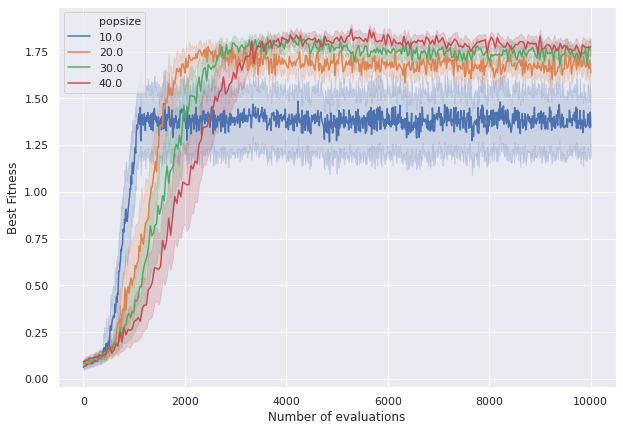

In [0]:
vis_evo_progress(df, "max", "popsize")
plt.xlabel("Number of evaluations")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

10.0 v.s. 20.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.688e-01 U_stat=3.010e+02
20.0 v.s. 30.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.740e+02
30.0 v.s. 40.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.540e+02
10.0 v.s. 30.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.113e-01 U_stat=3.180e+02
20.0 v.s. 40.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.830e+02
10.0 v.s. 40.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.333e-01 U_stat=3.200e+02


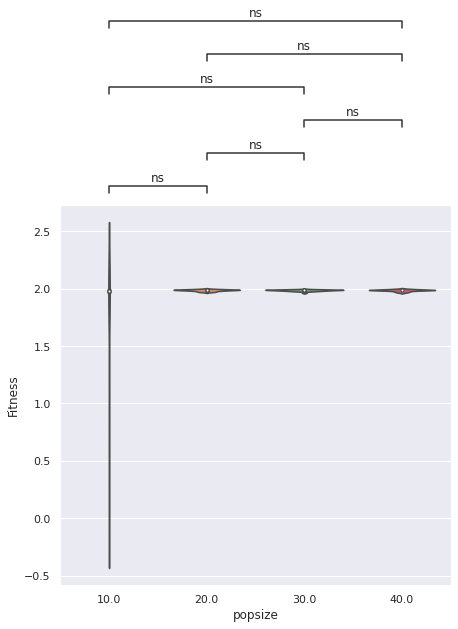

In [0]:
vis_evo_best(df, "max", "popsize")

## How the swarm or the population explore the search space?

It is more than often the above visualisations are the only things reported in PSO articles. But they may not be sufficient to fully confirm the effectiveness of a proposed technique (e.g. a new crossover operator). The better performance may achieve by some side-effects rather than what are conceptually designed. To truly understand the behaviour of the EC algorithms, we may have to analyse the generated solutions (genotypic or phenotypic).

Let's first modify the above PSO code to extract all generated solutions

In [0]:
def run_monitor(seed, popsize, maxeval):
    random.seed(seed)
    np.random.seed(seed)
    records = []
    pop = toolbox.population(n=popsize)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 100000
    best = None

    for g in range(GEN):
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if part.best is None or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if best is None or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        for part in pop:
            toolbox.update(part, best)

        # Gather all the fitnesses in one list and print the stats
        # logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        # print(logbook.stream)

        for i in range(len(pop)):
            records.append([g*popsize, i, pop[i].fitness.values[0]] + list(pop[i]))
        
        if (g+1)*popsize > maxeval:
            break
    
    return records #pop, logbook, best

In [0]:
def h1(x,y):
  return benchmarks.h1((x,y))[0]

def vis_search(outputs):
  H1 = np.vectorize(h1)
  plt.figure(figsize=(24,8))
  xlist = np.linspace(-25, 25, 1000)
  ylist = np.linspace(-25, 25, 1000)
  X, Y = np.meshgrid(xlist, ylist)
  Z = H1(X, Y)
  plt.subplot(131)
  contours = plt.contour(X, Y, Z, 15, colors='black')
  plt.clabel(contours, inline=True, fontsize=8)
  plt.imshow(Z, extent=[np.min(xlist), np.max(xlist), np.min(ylist), np.max(ylist)], origin='lower',
            cmap='hot', alpha=0.3)
  clb = plt.colorbar()
  clb.ax.set_title('Fitness')
  plt.scatter(outputs[:,-2], outputs[:,-1], c=outputs[:,0], marker="1", s=1, cmap="winter")
  plt.xlim(-25,25)
  plt.ylim(-25,25)

  xlist = np.linspace(2, 12, 1000)
  ylist = np.linspace(2, 12, 1000)
  X, Y = np.meshgrid(xlist, ylist)
  Z = H1(X, Y)

  plt.subplot(132)
  contours = plt.contour(X, Y, Z, 15, colors='black')
  plt.clabel(contours, inline=True, fontsize=8)
  plt.imshow(Z, extent=[np.min(xlist), np.max(xlist), np.min(ylist), np.max(ylist)], origin='lower',
            cmap='hot', alpha=0.3)
  plt.scatter(outputs[:,-2], outputs[:,-1], c=outputs[:,0], marker="1", s=2, cmap="winter")
  clb = plt.colorbar()
  clb.ax.set_title('Eval-step')
  plt.xlim(2,12)
  plt.ylim(2,12)

  plt.subplot(133)
  contours = plt.contour(X, Y, Z, 10, colors='black')
  plt.clabel(contours, inline=True, fontsize=8)
  plt.imshow(Z, extent=[np.min(xlist), np.max(xlist), np.min(ylist), np.max(ylist)], origin='lower',
            cmap='hot', alpha=0.3)
  plt.scatter(outputs[:,-2], outputs[:,-1], c=outputs[:,0], marker="1", s=3, cmap="winter")
  plt.xlim(6,10)
  plt.ylim(5,9)
  plt.suptitle("Winter is coming", fontsize=20)

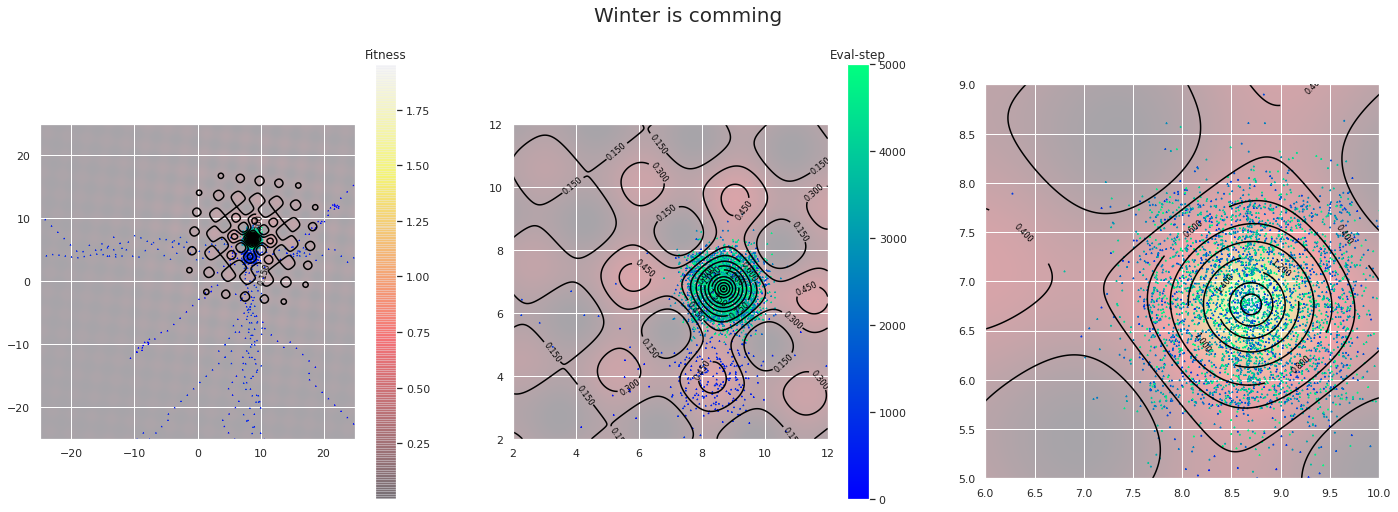

In [0]:
outputs = np.array(run_monitor(10, 10, 5000))
vis_search(outputs)

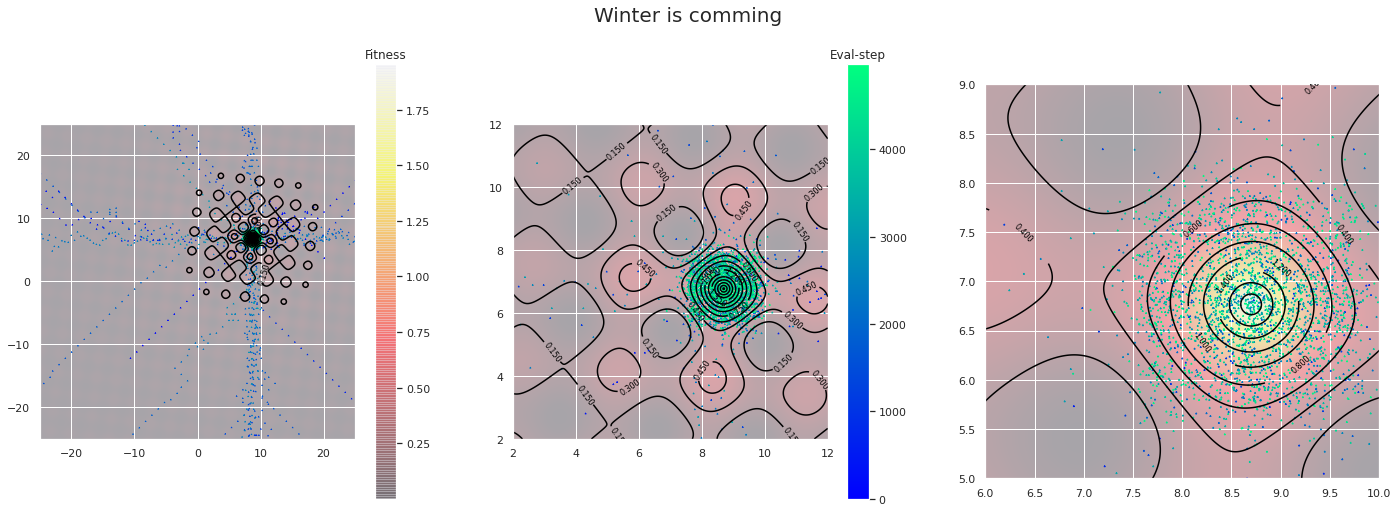

In [0]:
outputs = np.array(run_monitor(10, 30, 5000))
vis_search(outputs)

How to visualise the search process with high-dimensional solutions?

# Genetic programming for symbolic regression

In [0]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Define new functions
def protectedDiv(left, right):
    with numpy.errstate(divide='ignore',invalid='ignore'):
        x = numpy.divide(left, right)
        if isinstance(x, numpy.ndarray):
            x[numpy.isinf(x)] = 1
            x[numpy.isnan(x)] = 1
        elif numpy.isinf(x) or numpy.isnan(x):
            x = 1
    return x

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(numpy.add, 2, name="vadd")
pset.addPrimitive(numpy.subtract, 2, name="vsub")
pset.addPrimitive(numpy.multiply, 2, name="vmul")
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(numpy.negative, 1, name="vneg")
pset.addPrimitive(numpy.cos, 1, name="vcos")
pset.addPrimitive(numpy.sin, 1, name="vsin")
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

samples = numpy.linspace(-10, 10, 10000)
values = (1-samples)**7 - samples**6 + (1+samples)**5 - samples**4 + samples**3 - samples**2 + samples

def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression
    # and the real function values : x**4 + x**3 + x**2 + x 
    diff = numpy.mean((func(samples) - values)**2)
    return diff,

maxdepth=10
toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))



In [0]:
dtypes = numpy.dtype([
          ('seed', int),
          ('gen', int),
          ('mutate', float),
          ('id', int),
          ('fitness', float),
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)
for m in [0.1, 0.2]:
  for seed in range(1,31):
    records = run_genetic(seed=seed, popsize=100, ngen=50, mutateprob=m, crossprob=0.9)
    records = pd.DataFrame(np.array(records), columns=["gen","id","fitness"])
    records["seed"] = seed
    records["mutate"] = m
    df = df.append(records)
df.tail()

KeyboardInterrupt: ignored

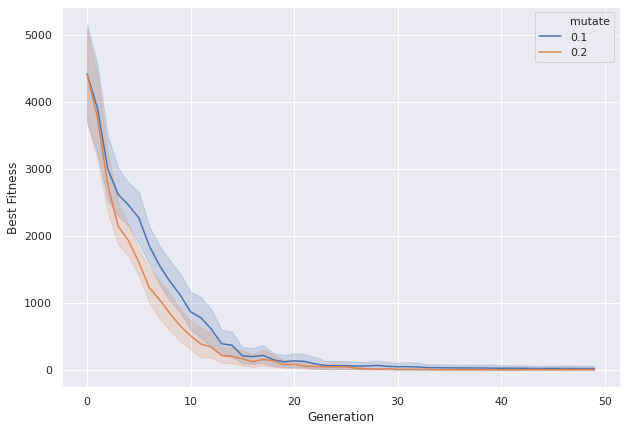

In [0]:
vis_evo_progress(df, "min", "mutate")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0.1 v.s. 0.2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.081e-02 U_stat=5.675e+02


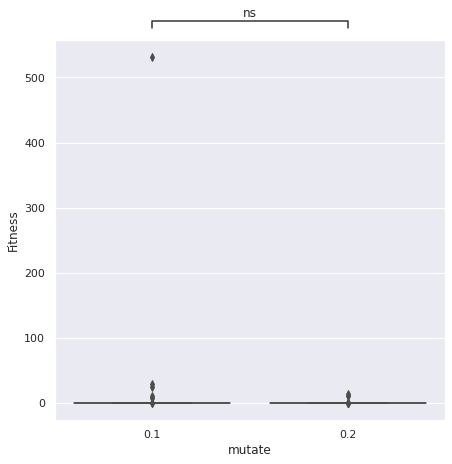

In [0]:
vis_evo_best(df, "min", "mutate")